In [1]:
%matplotlib inline

import numpy as np

In [2]:
import delfi

In [3]:
N = 2 

def Jeigs(params):
    """Calculates Jeigs.

        Parameters
        ---------- 
        params : np.array, 1d of length dim_param
            Parameter vector
        seed : int
        """
    
    u1 = params[0,:N]
    u2 = params[0,N:(2*N)]
    v1 = params[0,(2*N):(3*N)]
    v2 = params[0,(3*N):]

    U = np.stack((u1, u2), axis=1)
    V = np.stack((v1, v2), axis=1)

    J = np.matmul(U, np.transpose(V))
    Js = (J + np.transpose(J)) / 2.
    Js_eigs = np.linalg.eigvalsh(Js)
    Js_eig_max = np.max(Js_eigs, axis=0)

    # Take eig of low rank similar mat
    Jr = np.matmul(np.transpose(V), U) + 0.0001*np.eye(2)
    Jr_tr = np.trace(Jr)
    sqrt_term = np.square(Jr_tr) + -4.*np.linalg.det(Jr)
    J_eig_realmax = 0.5 * (Jr_tr + np.real(np.sqrt(sqrt_term)))

    return np.array([J_eig_realmax, Js_eig_max])

In [4]:
from delfi.simulator.BaseSimulator import BaseSimulator

class RNN(BaseSimulator):
    def __init__(self, N):
        """Hodgkin-Huxley simulator

        Parameters
        ----------
        I : array
            Numpy array with the input current
        dt : float
            Timestep
        V0 : float
            Voltage at first time step
        seed : int or None
            If set, randomness across runs is disabled
        """
        self.N = N
        self.r = 2
        dim_param = self.N*self.r*2

        super().__init__(dim_param=dim_param, seed=seed)
        self.Jeigs = Jeigs

    def gen_single(self, params):
        """Forward model for simulator for single parameter set

        Parameters
        ----------
        params : list or np.array, 1d of length dim_param
            Parameter vector

        Returns
        -------
        dict : dictionary with data
            The dictionary must contain a key data that contains the results of
            the forward run. Additional entries can be present.
        """
        params = np.asarray(params)

        assert params.ndim == 1, 'params.ndim must be 1'

        hh_seed = self.gen_newseed()

        states = self.Jeigs(params.reshape(1, -1))

        return {'data': states}

In [5]:
import delfi.distribution as dd

seed_p = 1
prior_min = -np.ones((4*N,))
prior_max = np.ones((4*N,))
prior = dd.Uniform(lower=prior_min, upper=prior_max,seed=seed_p)


In [6]:
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats
from scipy import stats as spstats

class RNNStats(BaseSummaryStats):
    """Moment based SummaryStats class for the Hodgkin-Huxley model

    Calculates summary statistics
    """
    def __init__(self, seed=None):
        """See SummaryStats.py for docstring"""
        super(RNNStats, self).__init__(seed=seed)

    def calc(self, repetition_list):
        """Calculate summary statistics

        Parameters
        ----------
        repetition_list : list of dictionaries, one per repetition
            data list, returned by `gen` method of Simulator instance

        Returns
        -------
        np.array, 2d with n_reps x n_summary
        """
        stats = []
        if len(repetition_list) > 1:
            print(repetition_list)
            raise NotImplementedError()
        for r in range(len(repetition_list)):
            x = repetition_list[r]

            stats.append(x['data'])
        return np.asarray(stats)

In [10]:
import delfi.generator as dg

seed = 0
# define model, prior, summary statistics and generator classes
m = RNN(N=N)
s = RNNStats()
g = dg.Default(model=m, prior=prior, summary=s)

In [11]:
n_processes = 10

seeds_m = np.arange(1,n_processes+1,1)
m = []
for i in range(n_processes):
    m.append(RNN(N=N))
g = dg.MPGenerator(models=m, prior=prior, summary=s)

In [12]:
# true parameters and respective labels
true_params = np.random.uniform(-1., 1., (4*N,))       
labels_params = [r'$T_1$', r'$T_2$']

# observed data: simulation given true parameters
obs = m[0].gen_single(true_params)

In [13]:
obs_stats = np.array([0.5, 1.5])

In [16]:
seed_inf = 1

pilot_samples = 2000

# training schedule
n_train = 2000
n_rounds = 2

# fitting setup
minibatch = 100
epochs = 100
val_frac = 0.05

# network setup
n_hiddens = [50,50]

# convenience
prior_norm = False

# MAF parameters
density = 'maf'
n_mades = 5


Entropy 10.477632987189882


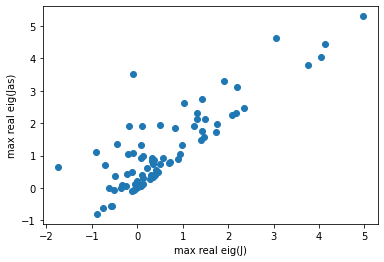

In [15]:
import delfi.inference as infer

# inference object
res = infer.SNPEC(g,
                obs=obs_stats,
                n_hiddens=n_hiddens,
                seed=seed_inf,
                pilot_samples=pilot_samples,
                n_mades=n_mades,
                prior_norm=prior_norm,
                density=density)

M = 100
nf = res.predict(x=obs_stats, deterministic=True)
z = nf.gen(M)

T_x = []
for m in range(M):
    T_x.append(Jeigs(z[m][None,:]))
    
T_x = np.array(T_x)

log_p_z = nf.eval(z)
H = -np.mean(log_p_z)
print('Entropy', H)

plt.figure()
plt.scatter(T_x[:,0], T_x[:,1])
plt.xlabel('max real eig(J)')
plt.ylabel('max real eig(Jas)')
plt.show()


In [17]:
# train
logs, trn_datasets, posteriors = res.run(
                    n_train=n_train,
                    n_rounds=n_rounds,
                    n_atoms=25,
                    minibatch=minibatch,
                    epochs=epochs,
                    silent_fail=False,
                    proposal='prior',
                    val_frac=val_frac,
                    verbose=True,)

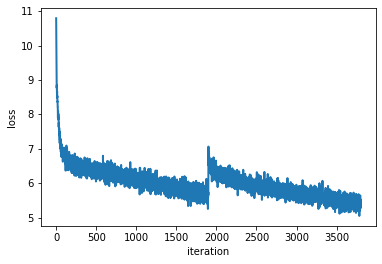

In [18]:
def plot_SNPEC_opt(logs, trn_datasets, posteriors):
    losses = [logs[i]['loss'] for i in range(len(logs))]
    loss = np.concatenate(losses, axis=0)
    plt.plot(loss,lw=2)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    
plot_SNPEC_opt(logs, trn_datasets, posteriors)

Entropy 7.183514536114632


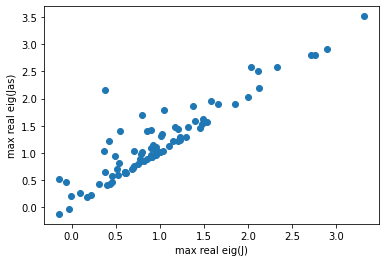

In [25]:
M = 100
nf = res.predict(x=obs_stats, deterministic=True)
z = nf.gen(M)

T_x = []
for m in range(M):
    T_x.append(Jeigs(z[m][None,:]))
    
T_x = np.array(T_x)

log_p_z = nf.eval(z)
H = -np.mean(log_p_z)
print('Entropy', H)

plt.figure()
plt.scatter(T_x[:,0], T_x[:,1])
plt.xlabel('max real eig(J)')
plt.ylabel('max real eig(Jas)')
plt.show()

In [36]:
print(nf)
x = np.tile(np.array([obs_stats]), (1, 1))
z_in = np.array([z[0]])
print(nf.eval(z_in))

[-83.77712939]
